### Imports

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from scipy.stats import ttest_ind

In [2]:
def bandpass_coefs(low=12, high=30, filter_order=4):
    fcs=[low, high]
    w = [fc/(fs / 2) for fc in fcs] # Normalize the frequency
    b, a = butter(filter_order, w, 'bandpass')
    return b, a

def process_psd(signal, b, a, time_start=0, window_time=0, fs=1000, plot=True):
    if not window_time:
        window = signal
    else:
        n_samples = window_time*fs
        start_samples = time_start*fs
        window = signal[start_samples:start_samples+n_samples]

    seconds = len(window)/fs
    t = np.arange(0, seconds, 1.0/fs)

    output = lfilter(b, a, window)

    sig_len = len(output)
    frq = np.linspace(0, fs, sig_len)
    frq = frq[:sig_len//2]

    psd = abs(np.fft.fft(output)[:sig_len//2])*(2/sig_len)

    if plot:
        fig, ax = plt.subplots(1, figsize=(14, 4))
        ax.plot(frq, psd)
        ax.set_xlim(9, 33)
    return psd, frq

def get_beta_rms(signal, window_time=30, n_windows=20, b=None, a=None):
    if b is None or a is None:
        b, a = bandpass_coefs(filter_order=4)

    time_starts = np.arange(0, window_time*n_windows, window_time)
    beta_rms = []
    for time_start in time_starts:
        psd, freq = process_psd(signal, time_start=time_start, window_time=window_time, b=b, a=a, plot=False)
        beta = np.array([p for p, f in zip(psd, freq) if f >= 12 and f <= 30])
        beta_rms.append(np.sqrt(np.mean(beta**2)))
    return beta_rms

In [3]:
fs = 1000
b, a = bandpass_coefs(filter_order=4)

## Dataset

Lesão Unilateral no Hemisfério Esquerdo (canais 1-32)
Hemisfério Direito saudável (canais 33-64)

Areas que serão comparadas:
- Putâmen
- Motor
- Globo pálido externo
- Globo pálido interno

In [4]:
data = loadmat('datasets/injuried/DATA_FP_Paty_20150203_baseline.mat', squeeze_me=True,  struct_as_record=False)
data.keys()
injuried_data = data.get('data')
injuried_data.lfp_id

array(['SPKC19', 'MI01L', 'MI02L', 'MI03L', 'MI04L', 'MI05L', 'PUT06L',
       'PUT07L', 'PUT08L', 'PUT09L', 'PUT10L', 'PUT11L', 'GPe12L',
       'GPe13L', 'GPe14L', 'GPe15L', 'GPi16L', 'GPi17L', 'GPi18L',
       'GPi19L', 'GPi20L', 'VL21L', 'VL22L', 'STN23L', 'STN24L', 'STN25L',
       'STN26L', 'VL27L', 'VL28L', 'VPL29L', 'VPL30L', 'VPL31L', 'VPL32L',
       'VL01R', 'VL02R', 'STN03R', 'STN04R', 'STN05R', 'STN06R', 'VL07R',
       'VL08R', 'VPL09R', 'VPL10R', 'VPL11R', 'VPL12R', 'GPi13R',
       'GPi14R', 'GPi15R', 'GPi16R', 'GPi17R', 'GPe18R', 'GPe19R',
       'GPe20R', 'GPe21R', 'PUT22R', 'PUT23R', 'PUT24R', 'PUT25R',
       'PUT26R', 'PUT27R', 'MI28R', 'MI29R', 'MI30R', 'MI31R', 'MI32R'],
      dtype=object)

In [5]:
### Getting channel_indexes manually according to previous lfp_id (previous_cell output). The SPKC19 is ignored
d = {
    'MI_L': [1, 2, 3, 4, 5],
    'PUT_L': [6, 7, 8, 9, 10, 11],
    'GPE_L': [12, 13, 14, 15],
    'GPI_L': [16, 17, 18, 19, 20],
    'VL_L': [21, 22, 27, 28, 29, 30, 31, 32],
    'STN_L': [23, 24, 25, 26],
    'MI_R': [60, 61, 62, 63, 64],
    'PUT_R': [54, 55, 56, 57, 58, 59],
    'GPE_R': [50, 51, 52, 53],
    'GPI_R': [45, 46, 47, 48, 49],
    'VL_R': [33, 34, 39, 40, 41, 42, 43, 44],
    'STN_R': [35, 36, 37, 38]
}

m1_left = np.array([injuried_data.lfp_samples[i] for i in d.get('MI_L')])
put_left = np.array([injuried_data.lfp_samples[i] for i in d.get('PUT_L')])
gpe_left = np.array([injuried_data.lfp_samples[i] for i in d.get('GPE_L')])
gpi_left = np.array([injuried_data.lfp_samples[i] for i in d.get('GPI_L')])

m1_right = np.array([injuried_data.lfp_samples[i] for i in d.get('MI_R')])
put_right = np.array([injuried_data.lfp_samples[i] for i in d.get('PUT_R')])
gpe_right = np.array([injuried_data.lfp_samples[i] for i in d.get('GPE_R')])
gpi_right = np.array([injuried_data.lfp_samples[i] for i in d.get('GPI_R')])

In [6]:
m1_left_rms = get_beta_rms(np.mean(m1_left, axis=0), b=b, a=a)
put_left_rms = get_beta_rms(np.mean(put_left, axis=0), b=b, a=a)
gpe_left_rms = get_beta_rms(np.mean(gpe_left, axis=0), b=b, a=a)
gpi_left_rms = get_beta_rms(np.mean(gpi_left, axis=0), b=b, a=a)

m1_right_rms = get_beta_rms(np.mean(m1_right, axis=0), b=b, a=a)
put_right_rms = get_beta_rms(np.mean(put_right, axis=0), b=b, a=a)
gpe_right_rms = get_beta_rms(np.mean(gpe_right, axis=0), b=b, a=a)
gpi_right_rms = get_beta_rms(np.mean(gpi_right, axis=0), b=b, a=a)

In [7]:
ttest_ind(m1_left_rms, m1_right_rms)

Ttest_indResult(statistic=0.46056973475000906, pvalue=0.6477323124849408)

Ttest_indResult(statistic=2.3605757888961683, pvalue=0.02348078431645061)

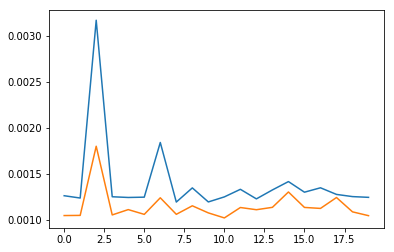

In [8]:
plt.plot(put_left_rms)
plt.plot(put_right_rms)
ttest_ind(put_left_rms, put_right_rms)

Ttest_indResult(statistic=2.832132295451007, pvalue=0.007356349735074196)

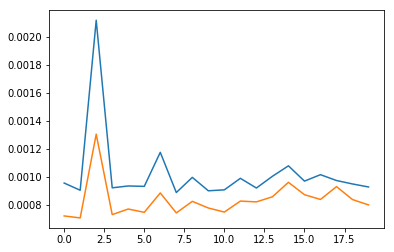

In [9]:
plt.plot(gpe_left_rms)
plt.plot(gpe_right_rms)
ttest_ind(gpe_left_rms, gpe_right_rms)

Ttest_indResult(statistic=5.714172013921853, pvalue=1.4043857443695016e-06)

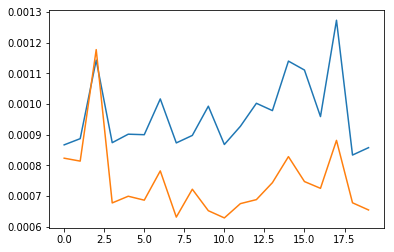

In [10]:
plt.plot(gpi_left_rms)
plt.plot(gpi_right_rms)
ttest_ind(gpi_left_rms, gpi_right_rms)